In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [3]:
#path = '../Data/car_dataset_sample/'
path1 = '../Data/car_dataset/HY_현대/'
path2 = '../Data/car_dataset/KI_기아/'

#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path1):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])

for folder, subfolders, filenames in os.walk(path2):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
        
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  161526
Image_labels: 161526


In [2]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  290400
Image_labels: 290400


In [3]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df
train

,image_id,dir,label
0,C_211012_NI_071_18_WH_A_P_01_034.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
1,C_211012_NI_071_18_WH_A_T_03_022.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
2,C_211012_NI_071_18_WH_A_P_01_064.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
3,C_211012_NI_071_18_WH_A_P_01_051.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
4,C_211012_NI_071_18_WH_A_P_01_058.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
...,...,...,...
290395,C_211129_JE_087_21_WH_A_T_03_004.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290396,C_211129_JE_087_21_WH_A_T_03_010.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290397,C_211129_JE_087_21_WH_A_P_01_057.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
290398,C_211129_JE_087_21_WH_A_P_01_011.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021


In [5]:
first = le.inverse_transform([100])
first

array(['닛산/알티마/2018'], dtype='<U18')

In [4]:
train['label'].value_counts()

벤츠/E-Class/2017       3566
현대/코나/2018            2755
기아/모닝/2017            2721
기아/K3/2019            2563
기아/스포티지/2018          2471
                      ... 
지프/랭글러/2021             91
쉐보레/볼트EV/2017           90
BMW/X3/2020             89
미니/Countryman/2021      79
지프/랭글러/2018             70
Name: label, Length: 370, dtype: int64

In [5]:
train['label'].value_counts().loc[lambda x : x < 900]

폭스바겐/골프/2017          864
기아/K5/2021            855
기아/스포티지/2020          855
현대/i30/2017           855
현대/엑센트/2017           854
                     ... 
지프/랭글러/2021            91
쉐보레/볼트EV/2017          90
BMW/X3/2020            89
미니/Countryman/2021     79
지프/랭글러/2018            70
Name: label, Length: 236, dtype: int64

In [6]:
low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

# for i, label in enumerate(train['label']):
#     #print(label)
#     if any(j in label for j in low_data) :
#         train.drop(i)
# train['label'].value_counts()

Index(['BMW/3시리즈/2019', 'BMW/3시리즈/2020', 'BMW/5시리즈/2019', 'BMW/5시리즈/2020',
       'BMW/5시리즈/2021', 'BMW/7시리즈/2017', 'BMW/7시리즈/2018', 'BMW/7시리즈/2019',
       'BMW/7시리즈/2020', 'BMW/X3/2017',
       ...
       '현대/코나/2021', '현대/투싼/2021', '현대/포터2/2018', '현대/포터2/2019', '현대/포터2/2020',
       '현대/포터2/2021', '혼다/CR-V/2017', '혼다/CR-V/2021', '혼다/어코드/2017',
       '혼다/어코드/2021'],
      dtype='object', length=236)

In [5]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train
# idx

,image_id,dir,label
0,C_210813_SS_097_18_BL_A_P_01_031.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
1,C_211217_SS_097_18_BL_A_P_01_057.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
2,C_211217_SS_097_18_BL_A_P_01_011.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
3,C_211217_SS_097_18_BL_A_P_01_065.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
4,C_211217_SS_097_18_BL_A_T_03_013.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,쌍용/티볼리/2018
...,...,...,...
206641,C_211116_BE_014_20_BL_A_P_01_007.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206642,C_211116_BE_014_20_BL_A_P_01_031.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206643,C_211116_BE_014_20_BL_A_P_01_016.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020
206644,C_211116_BE_014_20_BL_A_P_01_045.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,벤츠/E-Class/2020


In [6]:
train['label'].value_counts()

160    3566
349    2755
52     2721
24     2563
82     2471
       ... 
43      940
198     938
323     937
359     935
44      923
Name: label, Length: 134, dtype: int64

In [7]:
print(len(train.label))

206646


In [7]:
train.label.nunique()

134

In [6]:
label_value = train['label'].values
label_value

array(['쌍용/티볼리/2018', '쌍용/티볼리/2018', '쌍용/티볼리/2018', ...,
       '벤츠/E-Class/2020', '벤츠/E-Class/2020', '벤츠/E-Class/2020'],
      dtype=object)

In [7]:
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

# 인코딩한 데이터로 변환
le_encoded = le.transform(label_value)

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
train['label'] = new_cat
train

,image_id,dir,label
0,C_210813_SS_097_18_BL_A_P_01_031.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
1,C_211217_SS_097_18_BL_A_P_01_057.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
2,C_211217_SS_097_18_BL_A_P_01_011.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
3,C_211217_SS_097_18_BL_A_P_01_065.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
4,C_211217_SS_097_18_BL_A_T_03_013.jpg,../Data/car_dataset/SS_쌍용/097_티볼리/2018_파랑_트림A,83
...,...,...,...
206641,C_211116_BE_014_20_BL_A_P_01_007.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69
206642,C_211116_BE_014_20_BL_A_P_01_031.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69
206643,C_211116_BE_014_20_BL_A_P_01_016.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69
206644,C_211116_BE_014_20_BL_A_P_01_045.jpg,../Data/car_dataset/BE_벤츠/014_E-Class/2020_파랑_트림A,69


In [6]:
dist.destroy_process_group()

NameError: name 'dist' is not defined

In [8]:
project_name = 'train07_batch128_car_classification'
user = 'hojunking'
run_name = 'train07_car_classification_efficientnet_lite0'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Training start with epoch 40 



/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.parallel.DistributedDataParallel is deprecated and will be removed by the end of February 2023.
  warnings.warn(msg, DeprecatedFeatureWarning)
epoch 0 loss: 2.1940: 100%|█████████████████| 2987/2987 [41:45<00:00,  1.19it/s]

train accuracy = 0.22985
[[ 624  328  262 ...    1    3   13]
 [ 222 1016   67 ...    2    6   12]
 [ 188   64  851 ...    3    6    5]
 ...
 [   6    8    6 ...  603  322   15]
 [  12    6    4 ...  290  813   29]
 [   4    1    6 ...    5    3 1772]]



epoch 0 loss: 2.0898: 100%|█████████████████| 2584/2584 [04:41<00:00,  9.19it/s]


validation accuracy = 0.39204
[[110  44  29 ...   0   0   0]
 [ 22 120   6 ...   0   0   0]
 [ 38  10 171 ...   0   0   1]
 ...
 [  0   0   0 ...  83  13   0]
 [  0   0   0 ...  53  98   1]
 [  0   0   0 ...   0   0 173]]


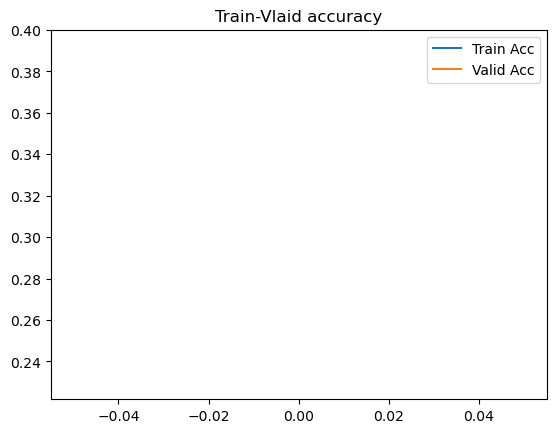

epoch 1 loss: 1.4230: 100%|█████████████████| 2987/2987 [42:00<00:00,  1.19it/s]


train accuracy = 0.49764
[[1448  361  233 ...    0    2    8]
 [ 320 1764   45 ...    1    0    0]
 [ 278   56 1394 ...    0    0    0]
 ...
 [   0    3    0 ... 1650  287    0]
 [   2    1    0 ...  535 1566    1]
 [   1    1    0 ...    1    3 2496]]


epoch 1 loss: 1.4183: 100%|█████████████████| 2584/2584 [04:37<00:00,  9.30it/s]


validation accuracy = 0.54258
[[150  47  27 ...   0   0   0]
 [ 13 150   5 ...   0   0   1]
 [ 32  18 196 ...   1   0   0]
 ...
 [  0   0   0 ... 117  14   0]
 [  0   0   0 ...  41 134   1]
 [  0   0   0 ...   0   0 197]]


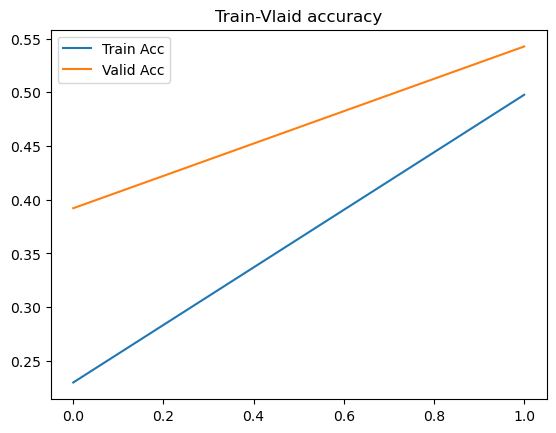

epoch 2 loss: 1.0506: 100%|█████████████████| 2987/2987 [41:44<00:00,  1.19it/s]


train accuracy = 0.62213
[[1858  292  195 ...    0    0    1]
 [ 262 2078   40 ...    0    0    0]
 [ 217   59 1716 ...    1    0    0]
 ...
 [   1    3    0 ... 2043  230    1]
 [   1    0    0 ...  468 1857    1]
 [   1    1    0 ...    1    0 2651]]


epoch 2 loss: 1.1060: 100%|█████████████████| 2584/2584 [04:34<00:00,  9.40it/s]


validation accuracy = 0.62797
[[213  21  16 ...   0   0   0]
 [ 15 164   0 ...   0   0   0]
 [ 35  16 236 ...   0   0   0]
 ...
 [  0   0   0 ... 136  20   0]
 [  0   0   0 ...  28 178   1]
 [  0   0   0 ...   0   0 205]]


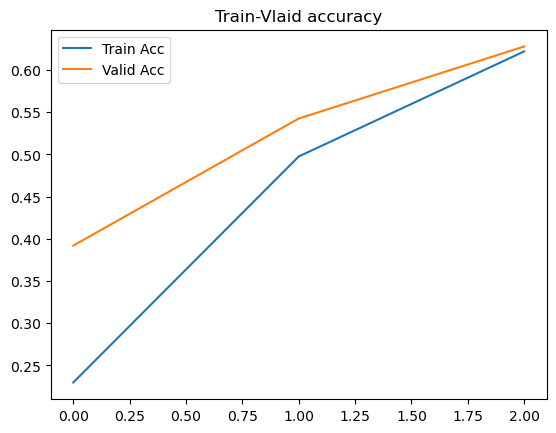

epoch 3 loss: 0.8343: 100%|█████████████████| 2987/2987 [41:50<00:00,  1.19it/s]


train accuracy = 0.70249
[[2122  236  169 ...    0    0    0]
 [ 202 2312   28 ...    0    0    0]
 [ 187   33 1981 ...    1    0    0]
 ...
 [   0    2    0 ... 2341  194    0]
 [   0    1    0 ...  397 2102    0]
 [   0    0    0 ...    1    2 2717]]


epoch 3 loss: 0.9074: 100%|█████████████████| 2584/2584 [04:33<00:00,  9.46it/s]


validation accuracy = 0.68725
[[197  34  19 ...   0   0   0]
 [  8 175   0 ...   0   0   0]
 [ 21  17 260 ...   0   0   0]
 ...
 [  0   0   0 ... 145  17   0]
 [  0   0   0 ...  20 183   1]
 [  0   0   0 ...   0   0 211]]


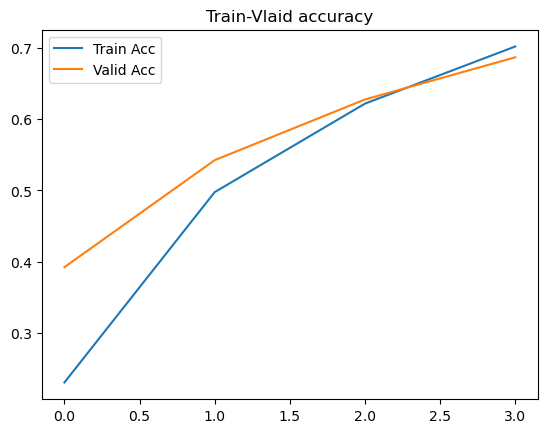

epoch 4 loss: 0.6559: 100%|█████████████████| 2987/2987 [41:25<00:00,  1.20it/s]


train accuracy = 0.76261
[[2271  205  132 ...    1    0    0]
 [ 164 2460   11 ...    0    1    0]
 [ 149   33 2141 ...    3    0    1]
 ...
 [   0    0    0 ... 2460  156    1]
 [   0    0    0 ...  260 2284    1]
 [   1    0    0 ...    0    0 2743]]


epoch 4 loss: 0.7760: 100%|█████████████████| 2584/2584 [04:34<00:00,  9.41it/s]


validation accuracy = 0.73119
[[219  19  18 ...   0   0   0]
 [ 14 168   4 ...   0   0   0]
 [ 25   6 304 ...   0   0   0]
 ...
 [  0   0   0 ... 151  15   0]
 [  0   0   0 ...  19 188   1]
 [  0   0   0 ...   0   0 208]]


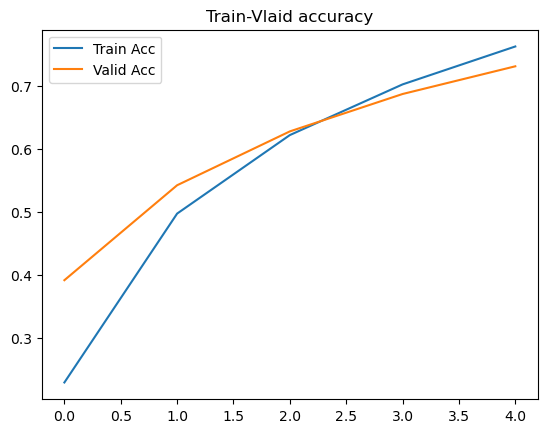

epoch 5 loss: 0.5380: 100%|█████████████████| 2987/2987 [41:27<00:00,  1.20it/s]

train accuracy = 0.80737
[[2364  171  105 ...    1    0    3]
 [ 119 2558   17 ...    0    0    0]
 [ 131   12 2326 ...    0    0    1]
 ...
 [   0    0    0 ... 2582  123    0]
 [   0    1    0 ...  179 2452    1]
 [   0    0    1 ...    0    0 2766]]



epoch 5 loss: 0.6800: 100%|█████████████████| 2584/2584 [04:36<00:00,  9.36it/s]


validation accuracy = 0.76247
[[221  15  23 ...   0   0   0]
 [ 14 172   3 ...   0   0   0]
 [ 10   7 340 ...   0   0   0]
 ...
 [  0   0   0 ... 163   6   0]
 [  0   0   0 ...   6 207   2]
 [  0   0   0 ...   0   0 217]]


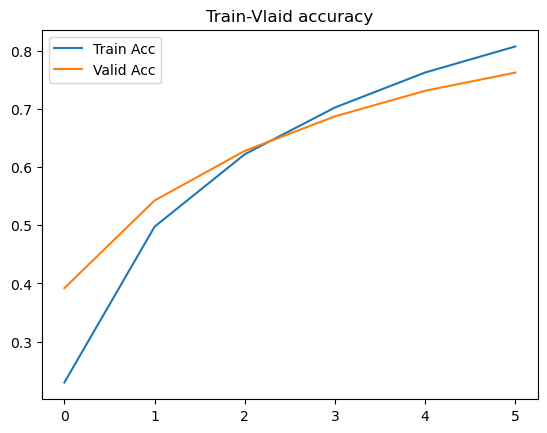

epoch 6 loss: 0.4471: 100%|█████████████████| 2987/2987 [41:28<00:00,  1.20it/s]


train accuracy = 0.84142
[[2487  125  107 ...    0    0    0]
 [  91 2608   14 ...    0    0    0]
 [ 103   15 2407 ...    0    0    0]
 ...
 [   0    0    0 ... 2652   86    0]
 [   0    0    0 ...  146 2547    0]
 [   0    0    0 ...    0    1 2785]]


epoch 6 loss: 0.6021: 100%|█████████████████| 2584/2584 [04:34<00:00,  9.41it/s]


validation accuracy = 0.79146
[[236   9  16 ...   0   0   0]
 [ 17 171   0 ...   0   0   0]
 [ 19   5 334 ...   0   0   0]
 ...
 [  0   0   0 ... 167   3   0]
 [  0   0   0 ...  10 198   1]
 [  0   0   0 ...   0   0 214]]


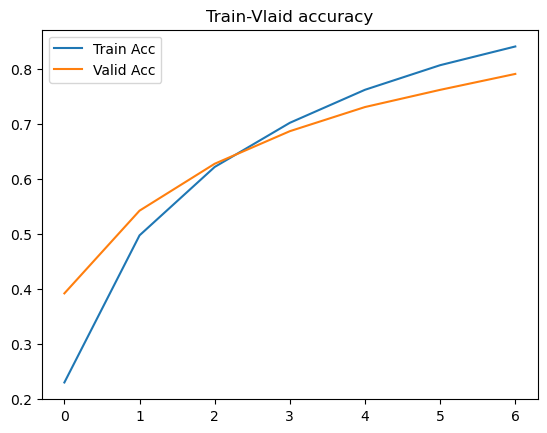

epoch 7 loss: 0.3804: 100%|█████████████████| 2987/2987 [41:29<00:00,  1.20it/s]


train accuracy = 0.86693
[[2546  119   72 ...    0    0    0]
 [  83 2655   12 ...    0    0    0]
 [ 103   13 2460 ...    0    0    0]
 ...
 [   0    0    0 ... 2706   59    1]
 [   0    0    0 ...  100 2647    0]
 [   0    0    1 ...    0    0 2792]]


epoch 7 loss: 0.5502: 100%|█████████████████| 2584/2584 [04:34<00:00,  9.41it/s]


validation accuracy = 0.80702
[[235  10  14 ...   0   0   0]
 [  8 184   0 ...   0   0   0]
 [ 12   7 338 ...   0   0   0]
 ...
 [  0   0   0 ... 172   2   0]
 [  0   0   0 ...   7 208   0]
 [  0   0   0 ...   0   0 215]]


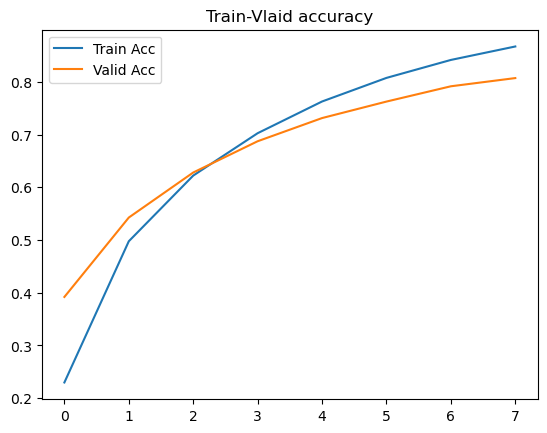

epoch 8 loss: 0.3231: 100%|█████████████████| 2987/2987 [41:35<00:00,  1.20it/s]


train accuracy = 0.88670
[[2606   96   73 ...    0    0    0]
 [  67 2706    8 ...    0    0    0]
 [  75    4 2539 ...    0    0    0]
 ...
 [   1    0    0 ... 2726   55    0]
 [   1    0    0 ...   79 2675    0]
 [   1    0    0 ...    0    1 2809]]


epoch 8 loss: 0.5037: 100%|█████████████████| 2584/2584 [04:34<00:00,  9.40it/s]


validation accuracy = 0.82308
[[241   6  19 ...   0   0   0]
 [ 12 173   1 ...   0   0   0]
 [ 11   5 351 ...   0   0   0]
 ...
 [  0   0   0 ... 173   5   0]
 [  0   0   1 ...   7 211   0]
 [  0   0   0 ...   0   0 216]]


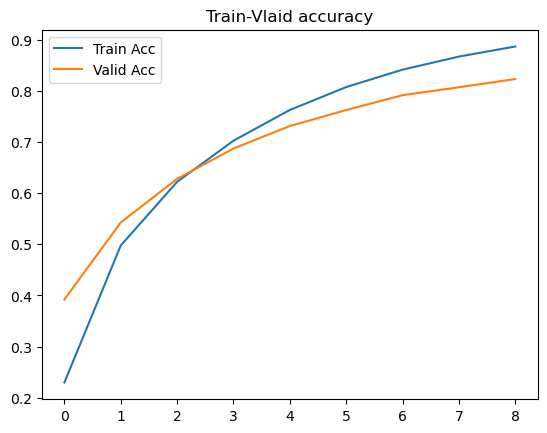

epoch 9 loss: 0.2801: 100%|█████████████████| 2987/2987 [41:27<00:00,  1.20it/s]


train accuracy = 0.90296
[[2646   78   42 ...    0    0    0]
 [  56 2714    5 ...    0    0    0]
 [  70   12 2559 ...    0    0    0]
 ...
 [   0    0    1 ... 2754   52    0]
 [   0    0    0 ...   63 2713    0]
 [   0    0    1 ...    0    0 2813]]


epoch 9 loss: 0.4822: 100%|█████████████████| 2584/2584 [04:34<00:00,  9.40it/s]


validation accuracy = 0.83080
[[244   9  12 ...   0   0   0]
 [  8 185   0 ...   0   0   0]
 [ 10   4 354 ...   0   0   0]
 ...
 [  0   0   0 ... 164   8   0]
 [  0   0   0 ...   1 217   1]
 [  0   0   0 ...   0   0 220]]


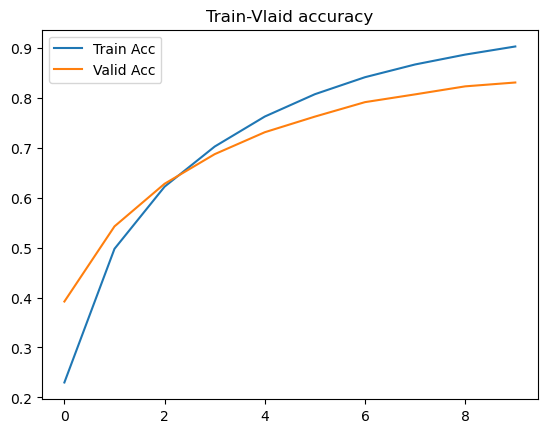

epoch 10 loss: 0.2387: 100%|████████████████| 2987/2987 [41:36<00:00,  1.20it/s]


train accuracy = 0.91479
[[2677   61   39 ...    0    0    0]
 [  60 2734    6 ...    0    0    0]
 [  55    6 2625 ...    0    0    0]
 ...
 [   1    0    0 ... 2769   43    0]
 [   0    0    0 ...   60 2730    0]
 [   0    0    0 ...    0    0 2818]]


epoch 10 loss: 0.4521: 100%|████████████████| 2584/2584 [04:35<00:00,  9.37it/s]


validation accuracy = 0.84079
[[248   7   8 ...   0   0   0]
 [ 10 184   0 ...   0   0   0]
 [ 10   5 357 ...   0   0   0]
 ...
 [  0   0   0 ... 174   4   0]
 [  0   0   0 ...   8 208   0]
 [  0   0   0 ...   0   0 213]]


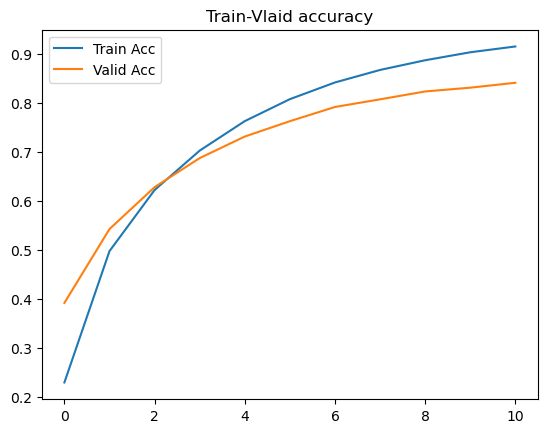

epoch 11 loss: 0.2183: 100%|████████████████| 2987/2987 [41:35<00:00,  1.20it/s]


train accuracy = 0.92612
[[2697   44   40 ...    0    0    0]
 [  45 2750    6 ...    0    0    0]
 [  48    4 2657 ...    0    0    1]
 ...
 [   0    0    0 ... 2784   30    0]
 [   0    1    0 ...   34 2754    0]
 [   0    0    0 ...    0    0 2824]]


epoch 11 loss: 0.4321: 100%|████████████████| 2584/2584 [04:34<00:00,  9.43it/s]


validation accuracy = 0.85233
[[252   3  10 ...   0   0   0]
 [ 13 181   0 ...   0   0   0]
 [ 14   2 356 ...   0   0   0]
 ...
 [  0   0   0 ... 173   3   0]
 [  0   0   0 ...   7 209   0]
 [  0   0   0 ...   0   0 218]]


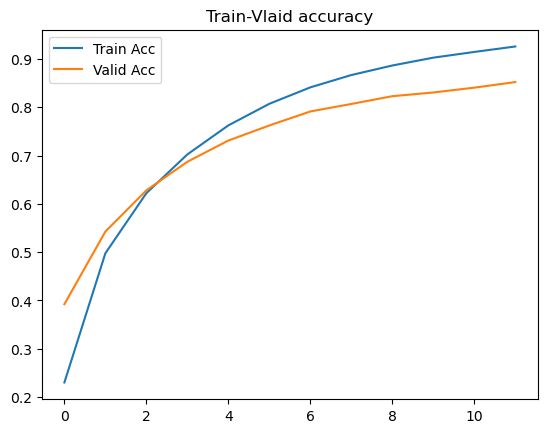

epoch 12 loss: 0.1871: 100%|████████████████| 2987/2987 [41:39<00:00,  1.20it/s]


train accuracy = 0.93481
[[2723   41   34 ...    0    0    0]
 [  31 2778    3 ...    0    0    0]
 [  28    3 2710 ...    1    0    0]
 ...
 [   0    0    0 ... 2795   33    0]
 [   0    0    0 ...   41 2758    0]
 [   0    0    0 ...    0    0 2826]]


epoch 12 loss: 0.4226: 100%|████████████████| 2584/2584 [04:34<00:00,  9.41it/s]


validation accuracy = 0.85613
[[257   5   4 ...   0   0   0]
 [ 10 181   1 ...   0   0   0]
 [ 17   3 341 ...   0   0   0]
 ...
 [  0   0   0 ... 173   4   0]
 [  0   0   0 ...   2 218   0]
 [  0   0   0 ...   0   0 219]]


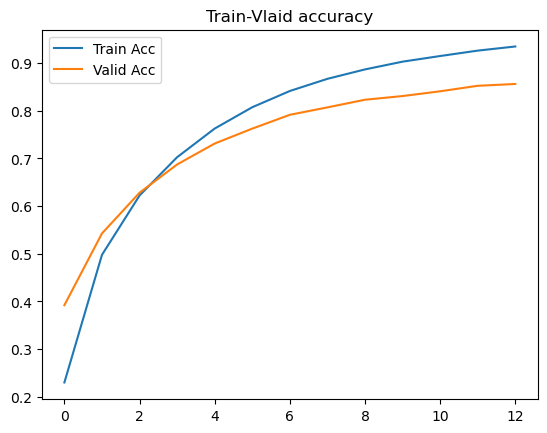

epoch 13 loss: 0.1699: 100%|████████████████| 2987/2987 [41:23<00:00,  1.20it/s]


train accuracy = 0.94061
[[2745   31   34 ...    0    0    0]
 [  19 2792    3 ...    0    0    0]
 [  37    4 2691 ...    0    0    0]
 ...
 [   0    0    0 ... 2797   25    0]
 [   0    0    0 ...   37 2776    0]
 [   0    0    0 ...    0    0 2834]]


epoch 13 loss: 0.4068: 100%|████████████████| 2584/2584 [04:33<00:00,  9.44it/s]


validation accuracy = 0.86109
[[252   7   8 ...   0   0   0]
 [  7 190   1 ...   0   0   0]
 [ 13   4 367 ...   0   0   0]
 ...
 [  0   0   0 ... 166   6   0]
 [  0   0   0 ...   1 217   1]
 [  0   0   0 ...   0   0 218]]


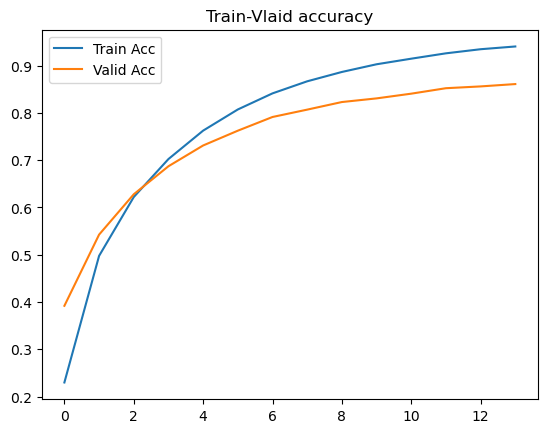

epoch 14 loss: 0.1547: 100%|████████████████| 2987/2987 [41:17<00:00,  1.21it/s]


train accuracy = 0.94728
[[2746   33   34 ...    0    0    0]
 [  26 2788    4 ...    0    0    0]
 [  33    3 2712 ...    0    0    0]
 ...
 [   0    0    0 ... 2795   24    0]
 [   0    0    0 ...   33 2786    0]
 [   0    0    0 ...    0    0 2837]]


epoch 14 loss: 0.4003: 100%|████████████████| 2584/2584 [04:33<00:00,  9.45it/s]


validation accuracy = 0.86617
[[259   4   3 ...   0   0   0]
 [  6 190   0 ...   0   0   0]
 [ 25   3 341 ...   0   0   0]
 ...
 [  0   0   0 ... 175   2   0]
 [  0   0   0 ...   6 214   0]
 [  0   0   0 ...   0   0 218]]


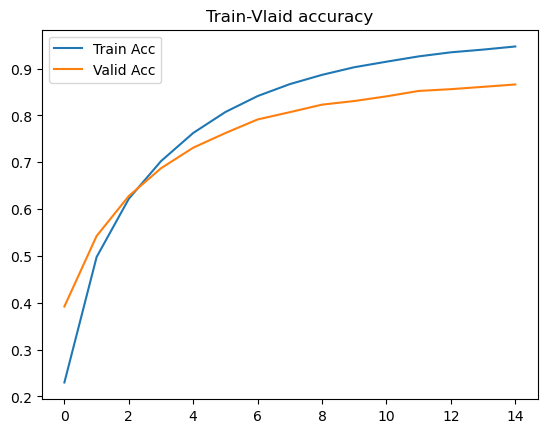

epoch 15 loss: 0.1384: 100%|████████████████| 2987/2987 [41:15<00:00,  1.21it/s]


train accuracy = 0.95200
[[2776   31   20 ...    0    0    0]
 [  19 2808    3 ...    0    0    0]
 [  22    3 2720 ...    0    0    0]
 ...
 [   0    0    0 ... 2816   18    0]
 [   0    0    0 ...   18 2802    0]
 [   0    0    0 ...    0    0 2832]]


epoch 15 loss: 0.3939: 100%|████████████████| 2584/2584 [04:34<00:00,  9.41it/s]


validation accuracy = 0.86811
[[255   3   9 ...   0   0   0]
 [  8 180   0 ...   0   0   0]
 [ 12   1 362 ...   0   0   0]
 ...
 [  0   0   0 ... 177   0   0]
 [  0   0   1 ...   1 216   0]
 [  0   0   0 ...   0   0 217]]


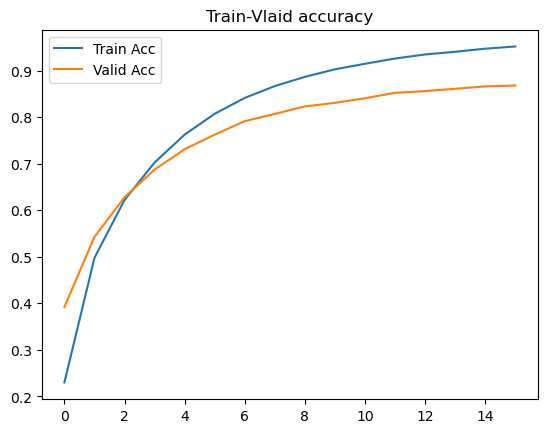

epoch 16 loss: 0.1255: 100%|████████████████| 2987/2987 [41:22<00:00,  1.20it/s]


train accuracy = 0.95642
[[2774   32   21 ...    0    0    0]
 [  31 2794    3 ...    1    0    0]
 [  15    4 2745 ...    0    0    0]
 ...
 [   0    0    0 ... 2809   25    0]
 [   0    0    0 ...   24 2795    0]
 [   0    0    0 ...    0    0 2836]]


epoch 16 loss: 0.3880: 100%|████████████████| 2584/2584 [04:34<00:00,  9.41it/s]


validation accuracy = 0.87159
[[249   8  10 ...   0   0   0]
 [  4 189   0 ...   0   0   0]
 [  8   4 370 ...   0   0   0]
 ...
 [  0   0   0 ... 171   6   0]
 [  0   0   0 ...   5 216   0]
 [  0   0   0 ...   0   0 211]]


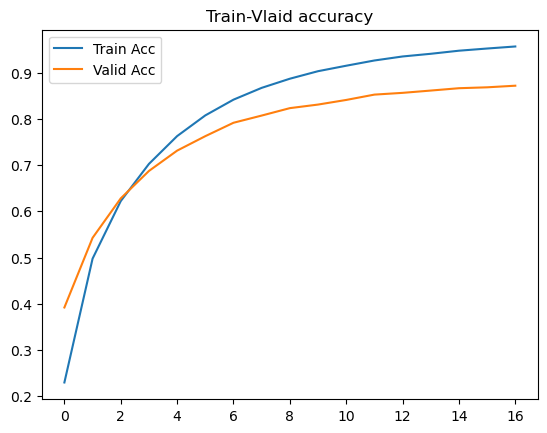

epoch 17 loss: 0.1167: 100%|████████████████| 2987/2987 [41:32<00:00,  1.20it/s]


train accuracy = 0.95998
[[2788   20   19 ...    0    0    0]
 [  21 2799    5 ...    0    0    0]
 [  23    2 2767 ...    0    0    0]
 ...
 [   0    0    0 ... 2811   23    0]
 [   0    0    0 ...   13 2814    0]
 [   0    0    0 ...    0    0 2841]]


epoch 17 loss: 0.3855: 100%|████████████████| 2584/2584 [04:33<00:00,  9.45it/s]


validation accuracy = 0.87576
[[251   3  14 ...   0   0   0]
 [ 12 176   0 ...   0   0   0]
 [  7   1 378 ...   0   0   0]
 ...
 [  0   0   0 ... 173   2   0]
 [  0   0   1 ...   5 212   0]
 [  0   0   0 ...   0   0 219]]


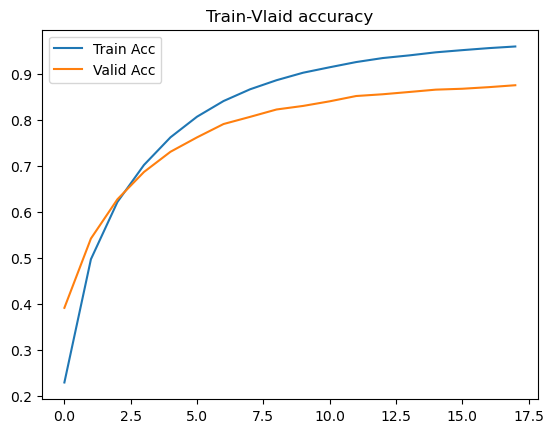

epoch 18 loss: 0.1076: 100%|████████████████| 2987/2987 [41:17<00:00,  1.21it/s]


train accuracy = 0.96327
[[2797   22   17 ...    0    0    1]
 [  17 2819    0 ...    0    0    0]
 [  18    0 2766 ...    0    0    0]
 ...
 [   0    0    0 ... 2825   11    0]
 [   0    0    0 ...   19 2813    0]
 [   0    0    0 ...    0    0 2839]]


epoch 18 loss: 0.3883: 100%|████████████████| 2584/2584 [04:34<00:00,  9.42it/s]


validation accuracy = 0.87578
[[259   4   7 ...   0   0   0]
 [  6 184   0 ...   0   0   0]
 [  6   2 365 ...   0   0   0]
 ...
 [  0   0   0 ... 175   1   0]
 [  0   0   1 ...   7 210   0]
 [  0   0   0 ...   0   0 218]]


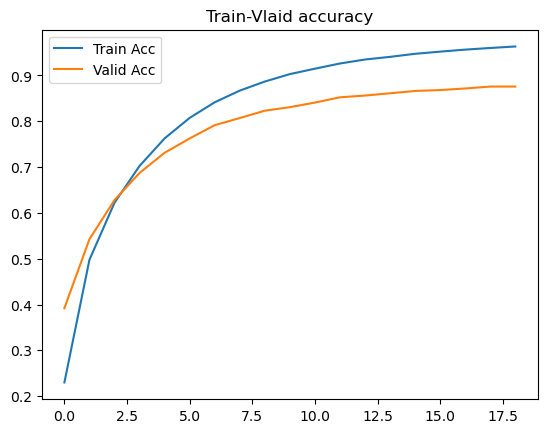

epoch 19 loss: 0.1021: 100%|████████████████| 2987/2987 [41:18<00:00,  1.20it/s]


train accuracy = 0.96507
[[2797   17   16 ...    0    0    0]
 [  20 2815    2 ...    0    0    0]
 [  16    1 2765 ...    0    0    0]
 ...
 [   0    0    0 ... 2825   18    0]
 [   0    0    0 ...   25 2817    0]
 [   0    0    0 ...    0    0 2835]]


epoch 19 loss: 0.3900: 100%|████████████████| 2584/2584 [04:35<00:00,  9.39it/s]


validation accuracy = 0.87726
[[261   2   7 ...   0   0   0]
 [  5 191   0 ...   0   0   0]
 [  8   5 372 ...   0   0   0]
 ...
 [  0   0   0 ... 176   3   0]
 [  0   0   1 ...   4 212   0]
 [  0   0   0 ...   0   0 221]]


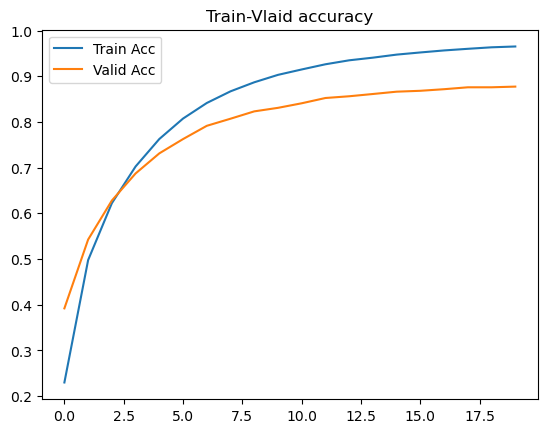

epoch 20 loss: 0.0990: 100%|████████████████| 2987/2987 [41:21<00:00,  1.20it/s]


train accuracy = 0.96795
[[2801   15   15 ...    0    0    0]
 [  17 2815    3 ...    0    0    0]
 [  12    2 2775 ...    0    0    0]
 ...
 [   0    0    0 ... 2831   16    0]
 [   0    0    0 ...   16 2809    0]
 [   0    0    0 ...    1    0 2836]]


epoch 20 loss: 0.3797: 100%|████████████████| 2584/2584 [04:34<00:00,  9.42it/s]


validation accuracy = 0.88052
[[257   3   9 ...   0   0   0]
 [ 10 181   0 ...   0   0   0]
 [  4   4 376 ...   0   0   0]
 ...
 [  0   0   0 ... 170   2   0]
 [  0   0   1 ...   5 210   0]
 [  0   0   0 ...   0   0 218]]


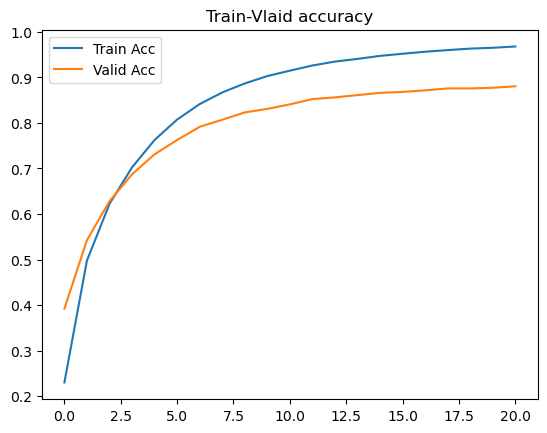

epoch 21 loss: 0.0881: 100%|████████████████| 2987/2987 [41:19<00:00,  1.20it/s]

train accuracy = 0.97030
[[2795   14   21 ...    0    0    0]
 [  14 2820    2 ...    0    0    0]
 [  22    2 2770 ...    0    0    0]
 ...
 [   0    0    0 ... 2839    4    0]
 [   0    0    0 ...   12 2817    0]
 [   0    0    0 ...    0    0 2842]]



epoch 21 loss: 0.3800: 100%|████████████████| 2584/2584 [04:35<00:00,  9.37it/s]


validation accuracy = 0.88294
[[253   3  12 ...   0   0   0]
 [  9 187   0 ...   0   0   0]
 [  6   4 376 ...   0   0   0]
 ...
 [  0   0   0 ... 174   3   0]
 [  0   0   1 ...   3 214   0]
 [  0   0   0 ...   0   0 219]]


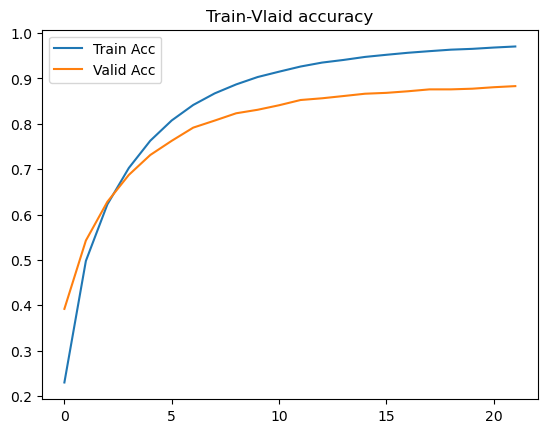

epoch 22 loss: 0.0842: 100%|████████████████| 2987/2987 [41:20<00:00,  1.20it/s]


train accuracy = 0.97218
[[2802   12   19 ...    0    0    0]
 [  10 2829    2 ...    0    1    0]
 [  15    1 2794 ...    0    0    0]
 ...
 [   0    0    0 ... 2827   13    0]
 [   1    0    0 ...   19 2814    0]
 [   0    0    0 ...    0    0 2837]]


epoch 22 loss: 0.3777: 100%|████████████████| 2584/2584 [04:35<00:00,  9.39it/s]


validation accuracy = 0.88301
[[256   2   9 ...   0   0   0]
 [  9 183   0 ...   0   0   0]
 [  7   4 367 ...   0   0   0]
 ...
 [  0   0   0 ... 174   3   0]
 [  0   0   1 ...   4 210   0]
 [  0   0   0 ...   0   0 215]]


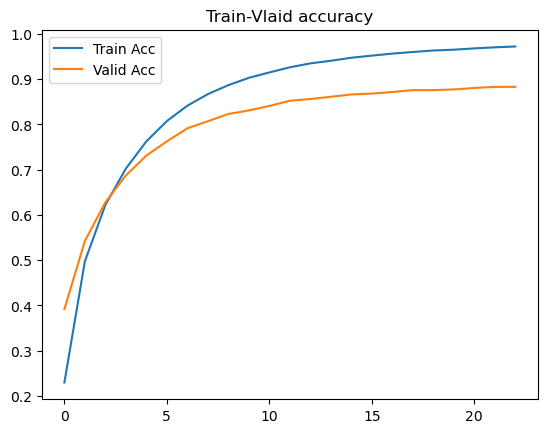

epoch 23 loss: 0.0766: 100%|████████████████| 2987/2987 [41:18<00:00,  1.21it/s]


train accuracy = 0.97395
[[2811   15    8 ...    0    0    0]
 [  11 2831    1 ...    0    0    0]
 [  13    1 2789 ...    0    0    0]
 ...
 [   0    0    0 ... 2826   10    0]
 [   0    0    0 ...   13 2824    0]
 [   0    0    0 ...    0    0 2841]]


epoch 23 loss: 0.3781: 100%|████████████████| 2584/2584 [04:35<00:00,  9.38it/s]


validation accuracy = 0.88437
[[256   6   8 ...   0   0   0]
 [  5 191   0 ...   0   0   0]
 [  6   1 386 ...   0   0   0]
 ...
 [  0   0   0 ... 174   4   0]
 [  0   0   1 ...   2 216   0]
 [  0   0   1 ...   0   0 217]]


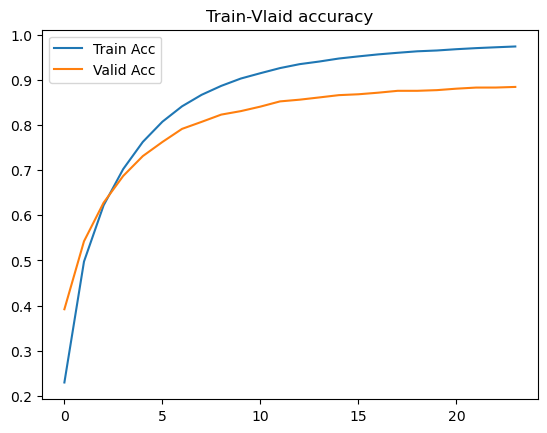

epoch 24 loss: 0.0759: 100%|████████████████| 2987/2987 [41:28<00:00,  1.20it/s]


train accuracy = 0.97524
[[2813   11   13 ...    0    0    0]
 [   9 2830    0 ...    0    0    0]
 [  15    2 2788 ...    0    0    0]
 ...
 [   0    0    0 ... 2828   12    0]
 [   0    0    0 ...   18 2822    0]
 [   0    0    0 ...    0    0 2846]]


epoch 24 loss: 0.3869: 100%|████████████████| 2584/2584 [04:36<00:00,  9.34it/s]


validation accuracy = 0.88488
[[255   3  10 ...   0   0   0]
 [  8 185   0 ...   0   0   0]
 [  4   2 375 ...   0   0   0]
 ...
 [  0   0   0 ... 175   5   0]
 [  0   0   1 ...   4 208   0]
 [  0   0   0 ...   0   0 219]]


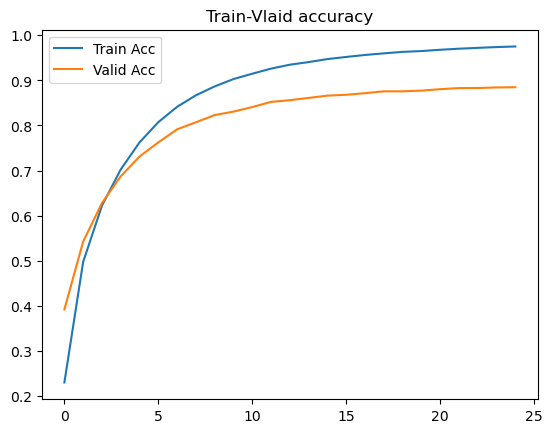

epoch 25 loss: 0.0529: 100%|████████████████| 2987/2987 [41:25<00:00,  1.20it/s]


train accuracy = 0.98225
[[2830    2    9 ...    0    0    0]
 [   2 2843    1 ...    0    0    0]
 [   7    1 2803 ...    0    0    0]
 ...
 [   0    0    0 ... 2843    5    0]
 [   0    0    0 ...    9 2829    0]
 [   0    0    0 ...    0    0 2850]]


epoch 25 loss: 0.3575: 100%|████████████████| 2584/2584 [04:35<00:00,  9.38it/s]


validation accuracy = 0.89296
[[258   6   6 ...   0   0   0]
 [  4 193   0 ...   0   0   0]
 [  9   1 378 ...   0   0   0]
 ...
 [  0   0   0 ... 173   5   0]
 [  0   0   1 ...   2 215   0]
 [  0   0   0 ...   0   0 218]]


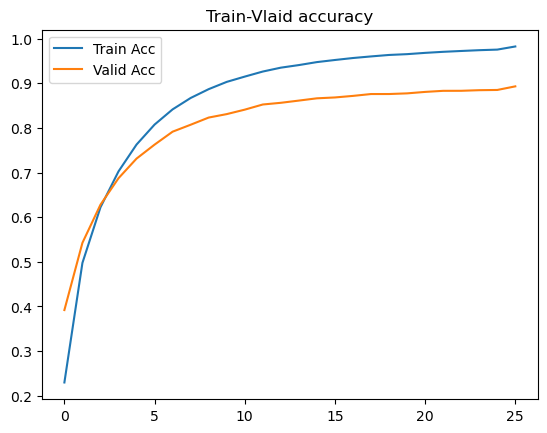

epoch 26 loss: 0.0502: 100%|████████████████| 2987/2987 [41:25<00:00,  1.20it/s]


train accuracy = 0.98391
[[2833    7    7 ...    0    0    0]
 [   4 2838    0 ...    0    0    0]
 [   8    1 2816 ...    0    0    0]
 ...
 [   0    0    0 ... 2838    6    0]
 [   0    0    0 ...    9 2835    0]
 [   0    0    0 ...    0    0 2850]]


epoch 26 loss: 0.3491: 100%|████████████████| 2584/2584 [04:37<00:00,  9.30it/s]


validation accuracy = 0.89485
[[258   3   6 ...   0   0   0]
 [  5 189   0 ...   0   0   0]
 [  2   2 386 ...   0   0   0]
 ...
 [  0   0   0 ... 179   2   0]
 [  0   0   1 ...   3 215   0]
 [  0   0   0 ...   0   0 219]]


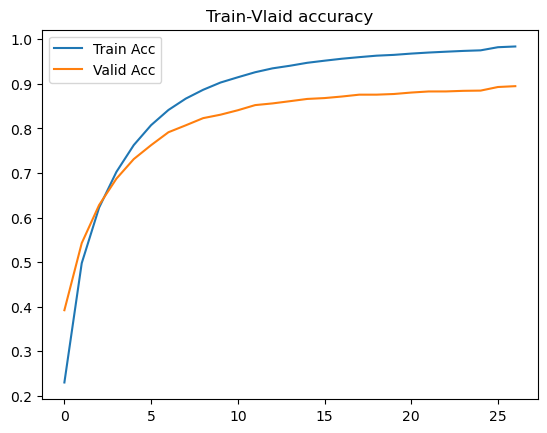

epoch 27 loss: 0.0481: 100%|████████████████| 2987/2987 [41:21<00:00,  1.20it/s]


train accuracy = 0.98480
[[2833    6    5 ...    0    0    0]
 [   6 2843    0 ...    0    0    0]
 [   6    1 2815 ...    0    0    0]
 ...
 [   0    0    0 ... 2842    6    0]
 [   0    0    0 ...    7 2838    0]
 [   0    0    0 ...    0    0 2848]]


epoch 27 loss: 0.3556: 100%|████████████████| 2584/2584 [04:36<00:00,  9.33it/s]


validation accuracy = 0.89608
[[263   2   5 ...   0   0   0]
 [  6 192   0 ...   0   0   0]
 [  8   1 377 ...   0   0   0]
 ...
 [  0   0   0 ... 175   4   0]
 [  0   0   1 ...   2 215   0]
 [  0   0   0 ...   0   0 218]]


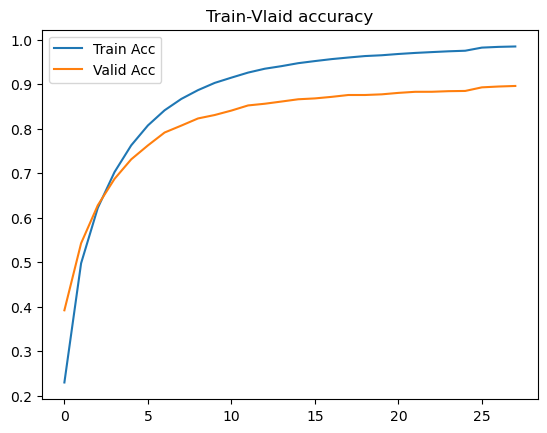

epoch 28 loss: 0.0447: 100%|████████████████| 2987/2987 [41:27<00:00,  1.20it/s]


train accuracy = 0.98552
[[2833    4    7 ...    0    0    0]
 [   6 2837    0 ...    0    0    0]
 [   4    3 2827 ...    0    0    0]
 ...
 [   0    0    0 ... 2836    8    0]
 [   0    0    0 ...    7 2834    0]
 [   0    0    0 ...    0    0 2848]]


epoch 28 loss: 0.3566: 100%|████████████████| 2584/2584 [04:38<00:00,  9.27it/s]


validation accuracy = 0.89564
[[263   4   3 ...   0   0   0]
 [  4 191   0 ...   0   0   0]
 [  9   2 374 ...   0   0   0]
 ...
 [  0   0   0 ... 175   3   0]
 [  0   0   0 ...   2 215   0]
 [  0   0   0 ...   0   0 218]]


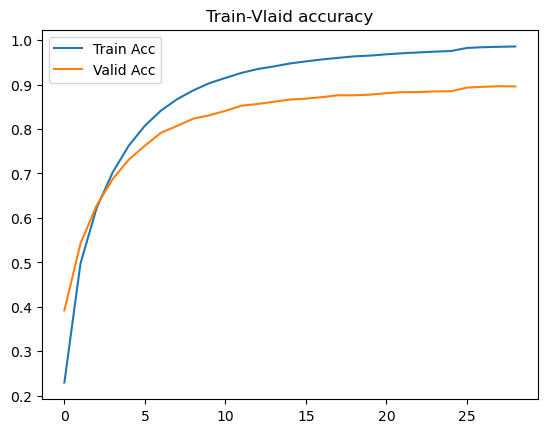

epoch 29 loss: 0.0437: 100%|████████████████| 2987/2987 [41:22<00:00,  1.20it/s]


train accuracy = 0.98633
[[2843    4    4 ...    0    0    0]
 [   7 2842    0 ...    0    0    0]
 [   5    0 2833 ...    0    0    0]
 ...
 [   0    0    0 ... 2843    4    0]
 [   0    0    0 ...    7 2836    0]
 [   0    0    0 ...    0    1 2845]]


epoch 29 loss: 0.3613: 100%|████████████████| 2584/2584 [04:37<00:00,  9.32it/s]


validation accuracy = 0.89497
[[260   5   5 ...   0   0   0]
 [  4 194   0 ...   0   0   0]
 [  5   2 385 ...   0   0   0]
 ...
 [  0   0   0 ... 173   5   0]
 [  0   0   1 ...   4 214   1]
 [  0   0   1 ...   0   0 220]]


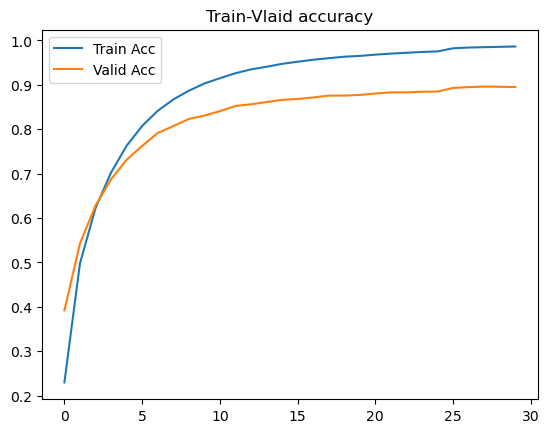

epoch 30 loss: 0.0433: 100%|████████████████| 2987/2987 [41:27<00:00,  1.20it/s]


train accuracy = 0.98704
[[2835    1    7 ...    0    0    0]
 [   3 2845    0 ...    0    0    0]
 [   6    0 2829 ...    0    0    0]
 ...
 [   0    0    0 ... 2843    6    0]
 [   0    0    0 ...    5 2837    1]
 [   0    0    0 ...    0    0 2851]]


epoch 30 loss: 0.3679: 100%|████████████████| 2584/2584 [04:37<00:00,  9.30it/s]


validation accuracy = 0.89506
[[258   6   6 ...   0   0   0]
 [  5 191   0 ...   0   0   0]
 [  4   3 384 ...   0   0   0]
 ...
 [  0   0   0 ... 176   4   0]
 [  0   0   1 ...   2 216   0]
 [  0   0   1 ...   0   0 215]]


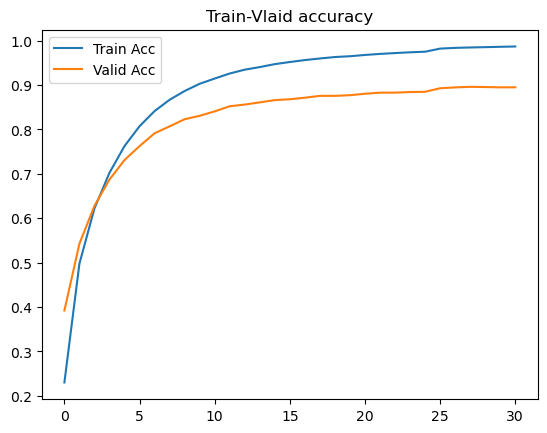

epoch 31 loss: 0.0406: 100%|████████████████| 2987/2987 [41:26<00:00,  1.20it/s]


train accuracy = 0.98741
[[2838    3    2 ...    1    0    0]
 [   8 2834    1 ...    0    0    0]
 [   2    0 2826 ...    0    0    0]
 ...
 [   0    0    0 ... 2838   10    0]
 [   0    0    0 ...   10 2834    0]
 [   0    0    0 ...    0    0 2851]]


epoch 31 loss: 0.3692: 100%|████████████████| 2584/2584 [04:39<00:00,  9.26it/s]


validation accuracy = 0.89579
[[262   5   3 ...   0   0   0]
 [  8 189   0 ...   0   0   0]
 [  7   2 381 ...   0   0   0]
 ...
 [  0   0   0 ... 177   0   0]
 [  0   0   1 ...   4 215   0]
 [  0   0   1 ...   0   0 219]]


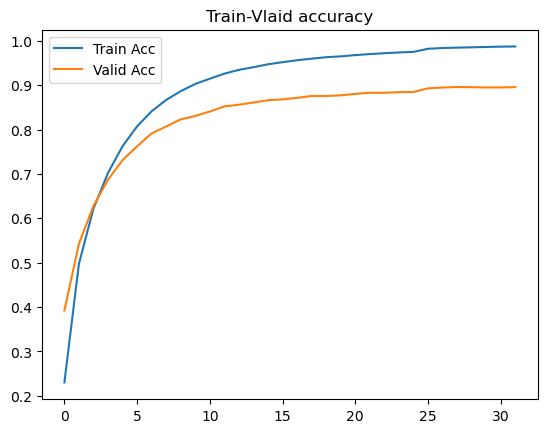

epoch 32 loss: 0.0403: 100%|████████████████| 2987/2987 [41:29<00:00,  1.20it/s]


train accuracy = 0.98776
[[2842    2    4 ...    0    0    0]
 [   2 2846    0 ...    0    0    0]
 [   7    1 2825 ...    0    0    0]
 ...
 [   0    0    0 ... 2846    4    0]
 [   0    0    0 ...    7 2842    0]
 [   0    0    0 ...    0    0 2852]]


epoch 32 loss: 0.3684: 100%|████████████████| 2584/2584 [04:39<00:00,  9.23it/s]


validation accuracy = 0.89681
[[260   4   5 ...   0   0   0]
 [ 10 183   0 ...   0   0   0]
 [  3   1 386 ...   0   0   0]
 ...
 [  0   0   0 ... 175   2   0]
 [  0   0   1 ...   2 216   0]
 [  0   0   1 ...   0   0 216]]


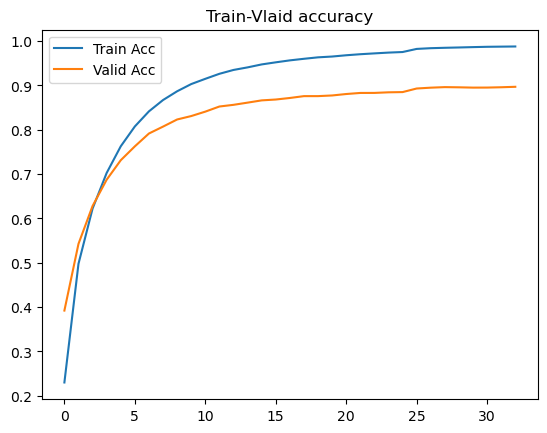

epoch 33 loss: 0.0392: 100%|████████████████| 2987/2987 [41:28<00:00,  1.20it/s]


train accuracy = 0.98836
[[2835    7    5 ...    0    0    0]
 [   3 2841    1 ...    0    0    0]
 [   6    1 2829 ...    0    0    0]
 ...
 [   0    0    0 ... 2841    4    0]
 [   0    0    0 ...    3 2841    0]
 [   0    0    0 ...    0    0 2849]]


epoch 33 loss: 0.3649: 100%|████████████████| 2584/2584 [04:38<00:00,  9.26it/s]


validation accuracy = 0.89681
[[262   3   5 ...   0   0   0]
 [ 10 182   0 ...   0   0   0]
 [  7   1 373 ...   0   0   1]
 ...
 [  0   0   0 ... 177   2   0]
 [  0   0   0 ...   4 212   0]
 [  0   0   0 ...   0   0 218]]


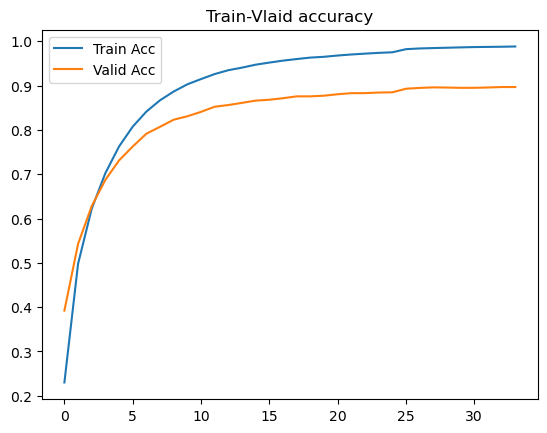

epoch 34 loss: 0.0332: 100%|████████████████| 2987/2987 [41:34<00:00,  1.20it/s]


train accuracy = 0.98899
[[2838    5    5 ...    0    0    0]
 [   7 2838    0 ...    0    0    0]
 [   3    1 2834 ...    0    0    0]
 ...
 [   0    0    0 ... 2841    5    0]
 [   0    0    0 ...    6 2842    0]
 [   0    0    0 ...    0    0 2848]]


epoch 34 loss: 0.3731: 100%|████████████████| 2584/2584 [04:38<00:00,  9.28it/s]


validation accuracy = 0.89729
[[262   4   5 ...   0   0   0]
 [  9 183   0 ...   0   0   0]
 [ 11   1 374 ...   0   0   1]
 ...
 [  0   0   0 ... 177   2   0]
 [  0   0   0 ...   2 217   0]
 [  0   0   0 ...   0   0 220]]


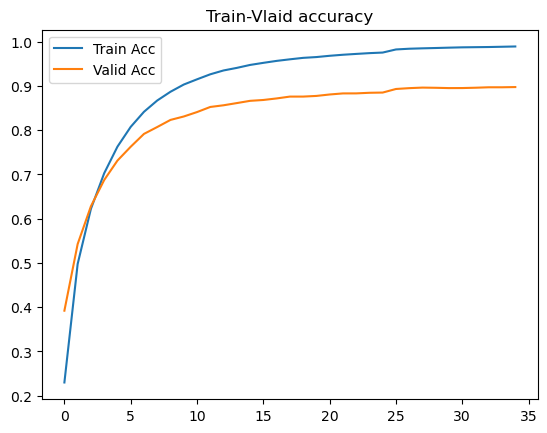

epoch 35 loss: 0.0368: 100%|████████████████| 2987/2987 [41:34<00:00,  1.20it/s]


train accuracy = 0.98895
[[2839    4    4 ...    0    0    0]
 [   6 2841    3 ...    0    0    0]
 [   7    1 2830 ...    0    0    0]
 ...
 [   0    0    0 ... 2843    6    0]
 [   0    0    0 ...    4 2843    0]
 [   0    0    0 ...    0    0 2852]]


epoch 35 loss: 0.3692: 100%|████████████████| 2584/2584 [04:39<00:00,  9.23it/s]


validation accuracy = 0.89637
[[262   2   5 ...   0   0   0]
 [  9 190   0 ...   0   0   0]
 [  8   1 384 ...   0   0   0]
 ...
 [  0   0   0 ... 180   1   0]
 [  0   0   1 ...   3 215   0]
 [  0   0   0 ...   0   0 219]]


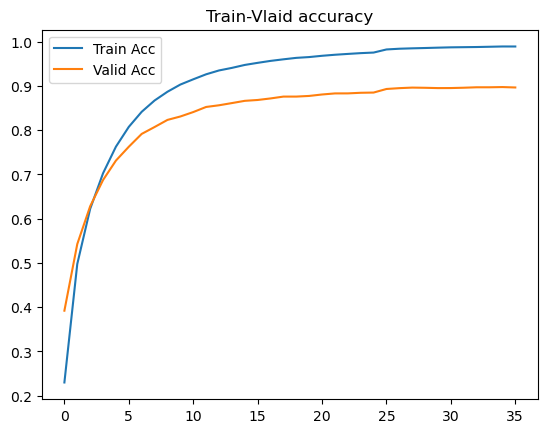

epoch 36 loss: 0.0337: 100%|████████████████| 2987/2987 [41:40<00:00,  1.19it/s]


train accuracy = 0.98924
[[2838    3    3 ...    0    0    0]
 [   1 2848    0 ...    0    0    0]
 [   8    0 2823 ...    0    0    0]
 ...
 [   0    0    0 ... 2844    6    0]
 [   0    0    0 ...    7 2837    0]
 [   0    0    0 ...    0    0 2848]]


epoch 36 loss: 0.3752: 100%|████████████████| 2584/2584 [04:41<00:00,  9.18it/s]


validation accuracy = 0.89673
[[259   2   8 ...   0   0   0]
 [  3 193   0 ...   0   0   0]
 [  5   1 390 ...   0   0   0]
 ...
 [  0   0   0 ... 177   3   0]
 [  0   0   1 ...   1 223   0]
 [  0   0   1 ...   0   0 219]]


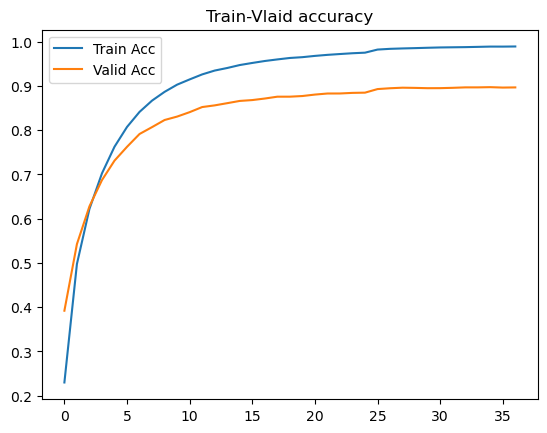

epoch 37 loss: 0.0338: 100%|████████████████| 2987/2987 [41:42<00:00,  1.19it/s]


train accuracy = 0.98985
[[2838    4    4 ...    0    0    0]
 [   5 2841    0 ...    0    0    0]
 [   5    2 2828 ...    0    0    0]
 ...
 [   0    0    0 ... 2849    3    0]
 [   0    0    0 ...    3 2847    0]
 [   0    0    0 ...    0    0 2850]]


epoch 37 loss: 0.3731: 100%|████████████████| 2584/2584 [04:42<00:00,  9.16it/s]


validation accuracy = 0.89775
[[262   4   5 ...   0   0   0]
 [  5 194   0 ...   0   0   0]
 [  3   4 385 ...   0   0   0]
 ...
 [  0   0   0 ... 176   3   0]
 [  0   0   1 ...   2 216   0]
 [  0   0   0 ...   0   0 219]]


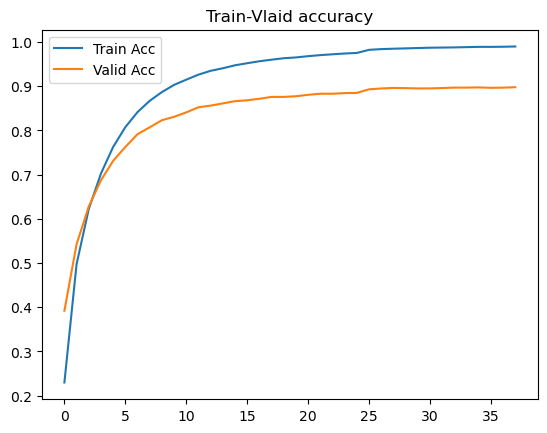

epoch 38 loss: 0.0346: 100%|████████████████| 2987/2987 [41:40<00:00,  1.19it/s]


train accuracy = 0.99014
[[2841    3    3 ...    0    0    0]
 [   2 2846    0 ...    0    0    0]
 [   2    0 2830 ...    0    0    0]
 ...
 [   0    0    0 ... 2836   11    0]
 [   0    0    0 ...   10 2835    0]
 [   0    0    0 ...    0    0 2850]]


epoch 38 loss: 0.3819: 100%|████████████████| 2584/2584 [04:42<00:00,  9.15it/s]


validation accuracy = 0.89693
[[262   3   5 ...   0   0   0]
 [ 10 182   0 ...   0   0   0]
 [  6   2 383 ...   0   0   0]
 ...
 [  0   0   0 ... 174   5   0]
 [  0   0   0 ...   3 217   0]
 [  0   0   1 ...   0   0 216]]


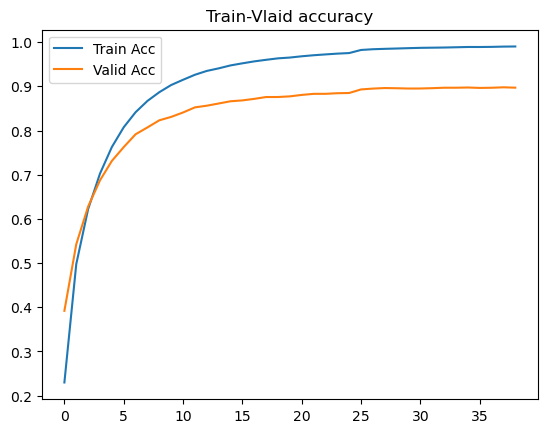

epoch 39 loss: 0.0326: 100%|████████████████| 2987/2987 [41:44<00:00,  1.19it/s]


train accuracy = 0.98999
[[2841    3    4 ...    0    0    0]
 [   3 2844    1 ...    0    0    0]
 [   4    1 2837 ...    0    0    0]
 ...
 [   0    0    0 ... 2845    5    0]
 [   0    0    0 ...    6 2842    0]
 [   0    0    0 ...    0    0 2851]]


epoch 39 loss: 0.3764: 100%|████████████████| 2584/2584 [04:42<00:00,  9.15it/s]


validation accuracy = 0.89693
[[263   4   4 ...   0   0   0]
 [  2 192   0 ...   0   0   0]
 [  4   3 383 ...   0   0   0]
 ...
 [  0   0   0 ... 174   1   0]
 [  0   0   1 ...   2 217   1]
 [  0   0   1 ...   0   0 217]]


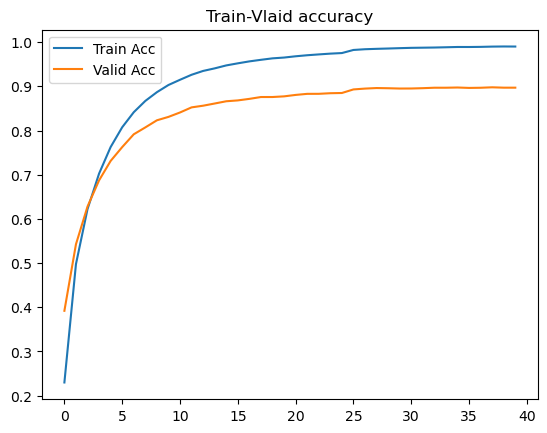

time : 1 day, 6:45:23
Best Epoch : 37/ 40
Best Train Accuracy : 0.98985
[[2838    4    4 ...    0    0    0]
 [   5 2841    0 ...    0    0    0]
 [   5    2 2828 ...    0    0    0]
 ...
 [   0    0    0 ... 2849    3    0]
 [   0    0    0 ...    3 2847    0]
 [   0    0    0 ...    0    0 2850]]
Best Valid Accuracy : 0.89775
[[262   4   5 ...   0   0   0]
 [  5 194   0 ...   0   0   0]
 [  3   4 385 ...   0   0   0]
 ...
 [  0   0   0 ... 176   3   0]
 [  0   0   1 ...   2 216   0]
 [  0   0   0 ...   0   0 219]]


AttributeError: 'DistributedDataParallel' object has no attribute 'cnn_model'

AttributeError: 'DistributedDataParallel' object has no attribute 'cnn_model'

In [9]:
%run classification_train_efficientnet2.ipynb

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


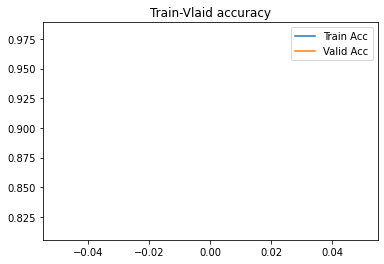

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


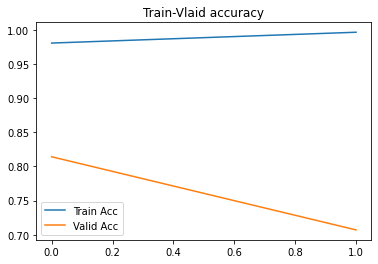

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


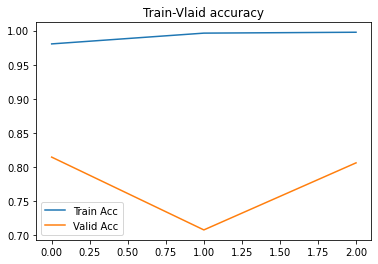

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


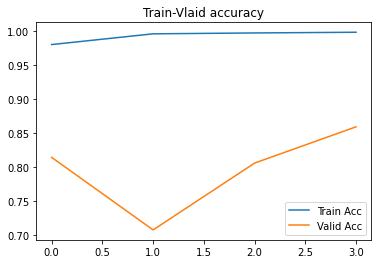

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


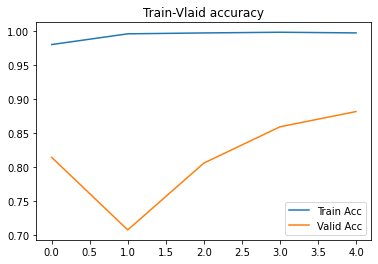

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb